###### read more about  Latent Dirichlet Allocation (LDA) method in the python using sklearn implementation.
https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0

In [1]:
# import json
import pandas as pd
import numpy as np
import nltk
import spacy
from datetime import datetime
import gensim
import gensim.corpora as corpora
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.test.utils import get_tmpfile, datapath
from gensim.utils import simple_preprocess
from nltk.corpus import stopwords
import warnings
warnings.filterwarnings("ignore")

unable to import 'smart_open.gcs', disabling that module


In [4]:
# load csv file

df = pd.read_csv("news_web.csv")

#drop unwanted column
df = df.drop(columns = 'Unnamed: 0' )
df.head()

,author,date,like_facebook,summary,tags,title
0,Himani Chandna,"25 April, 2020 2:50 pm IST",9879,The Ayush Ministry missive comes after PM Modi...,"Politics,Pre-Truth,Governance,Diplomacy,Econom...",Modi govt wants states to start producing herb...
1,PTI,"25 April, 2020 11:56 am IST",11020,The shops allowed to open will have to functio...,"Politics,Pre-Truth,Governance,Diplomacy,Econom...","New MHA order allows shops to open, but malls,..."
2,PTI,"25 April, 2020 5:00 pm IST",5102,The number of coronavirus cases in Karnataka h...,"Politics,Pre-Truth,Governance,Diplomacy,Econom...",Journalist who visited Bengaluru hotspots amon...
3,Simrin Sirur,"25 April, 2020 12:03 pm IST",7980,Ahmedabad is one of India’s worst-affected cit...,"Politics,Pre-Truth,Governance,Diplomacy,Econom...","‘Low testing, no healthcare’ — residents of Ah..."
4,Taruka Srivastav,"25 April, 2020 1:26 pm IST",19537,"During the Covid-19 crisis, people in Rajastha...","Politics,Pre-Truth,Governance,Diplomacy,Econom...",Rajasthan and Kerala can teach the world how t...


In [10]:
# saving df to pickle
df.to_pickle('./news_web.pkl')

In [11]:
raw_df = pd.read_pickle('./news_web.pkl')

##### converting string to datetime, dropping null/duplicate values

In [106]:

# def cleandata(raw_df):
 
from dateutil import parser

def convert_to_dt(s):
    try:
        return parser.parse(s)
    except Exception:
        return np.nan 

In [107]:
from dateutil import parser
s= '25 April, 2020, 2:50, pm, IST'

parser.parse("Tue Jun 22 07:46:22 EST 2010")
parser.parse(s)
# dt = datetime.strptime('25 April, 2020, 2:50, pm, IST', '%d %B, %Y, %I:%M, %p, %Z')
# # dt = datetime.strptime('25 April, 2020, 2:50, pm', '%d %B, %Y, %I:%M, %p')


# convert_to_dt(s)

datetime.datetime(2020, 4, 25, 14, 50)

In [149]:
"columns into another df  "

new_df = raw_df[['date','summary','title']]

" checking null value"
print(new_df.isnull().count(),"\n")

print(new_df.count(),"\n")

print(new_df['summary'].isna().count(),"\n")
print(new_df['summary'].count(),"\n")
print(new_df['summary'].tail(),"\n")

date       2958
summary    2958
title      2958
dtype: int64 

date       2958
summary    2955
title      2958
dtype: int64 

2958 

2955 

2953    On citizenship Act, Shiv Sena’s deputy leader ...
2954    The US Embassy in New Delhi has listed out pre...
2955    The Bharat Bachao rally was attended by Congre...
2956    Jamia Milia Islamia saw massive protests Frida...
2957    Besides Abdullah, his son and former chief min...
Name: summary, dtype: object 



In [151]:
new_df.dropna(inplace = True)

" checking null value"
print(new_df.isnull().count(),"\n")

print(new_df.count(),"\n")


date       2955
summary    2955
title      2955
dtype: int64 

date       2955
summary    2955
title      2955
dtype: int64 



In [109]:
print(new_df.date.head(3))

0      25 April, 2020 2:50 pm IST
1     25 April, 2020 11:56 am IST
2      25 April, 2020 5:00 pm IST
Name: date, dtype: object


In [113]:
new_df['date'] = new_df['date'].apply(convert_to_dt)
new_df['date'].tail(3)

2955   2019-12-14 17:14:00
2956   2019-12-14 16:20:00
2957   2019-12-14 17:05:00
Name: date, dtype: datetime64[ns]

## Preprocessing


In [129]:
" Helper Functions "

def article_to_words(articles):
    '''tokenizes articles; yeilds list of words for each article'''
    for article in articles:
        yield(gensim.utils.simple_preprocess(article, deacc=True))  # deacc=True removes punctuations
        
def remove_stopwords(texts):
    stop_words = stopwords.words('english')
    stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'say', 'also', 'would', 'may'])
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    '''Applies the bigram model(defined below) on each document'''
    return [bigram_mod[doc] for doc in texts]

nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [134]:
def preprocess(new_df):
    '''
    Input: clean dataframe
    Output: list of articles after preprocess, bigram model
    '''
    "Corpus of content of all articles"
    articles = list(new_df['summary'])  
    
    " Each article is a list of all it's words after simple_preprocess"
    data_words = list(article_to_words(articles))        
    
    common_terms = ["of", "with", "without", "and", "or", "the", "a"]
    
    " higher threshold fewer phrases."
    bigram = gensim.models.Phrases(data_words, min_count=4, threshold=30, common_terms=common_terms)
    
    " wrapper "
    bigram_mod = gensim.models.phrases.Phraser(bigram)                  
    
    return data_words, bigram_mod

In [136]:
new_df.head()

,date,summary,title
0,2020-04-25 14:50:00,The Ayush Ministry missive comes after PM Modi...,Modi govt wants states to start producing herb...
1,2020-04-25 11:56:00,The shops allowed to open will have to functio...,"New MHA order allows shops to open, but malls,..."
2,2020-04-25 17:00:00,The number of coronavirus cases in Karnataka h...,Journalist who visited Bengaluru hotspots amon...
3,2020-04-25 12:03:00,Ahmedabad is one of India’s worst-affected cit...,"‘Low testing, no healthcare’ — residents of Ah..."
4,2020-04-25 13:26:00,"During the Covid-19 crisis, people in Rajastha...",Rajasthan and Kerala can teach the world how t...


date       2958
summary    2955
title      2958
dtype: int64


2958

In [152]:
data_words, bigram_mod = preprocess(new_df)


In [157]:
" tolkenization"
data_words[0:3]

[['the',
  'ayush',
  'ministry',
  'missive',
  'comes',
  'after',
  'pm',
  'modi',
  'on',
  'april',
  'recommended',
  'the',
  'use',
  'of',
  'alternative',
  'medicine',
  'to',
  'strengthen',
  'immunity',
  'against',
  'covid'],
 ['the',
  'shops',
  'allowed',
  'to',
  'open',
  'will',
  'have',
  'to',
  'function',
  'with',
  'strength',
  'of',
  'workers',
  'who',
  'will',
  'have',
  'to',
  'wear',
  'masks',
  'and',
  'follow',
  'social',
  'distancing'],
 ['the',
  'number',
  'of',
  'coronavirus',
  'cases',
  'in',
  'karnataka',
  'has',
  'risen',
  'to',
  'of',
  'whom',
  'have',
  'been',
  'discharged']]

In [164]:
bigram_mod

In [165]:
data_words_lemmatized = lemmatization(data_words)

In [167]:
data_words_lemmatized[0:3]

[['missive',
  'come',
  'pm',
  'modi',
  'recommend',
  'use',
  'alternative',
  'medicine',
  'strengthen',
  'immunity'],
 ['shop',
  'allow',
  'open',
  'will',
  'function',
  'strength',
  'worker',
  'will',
  'wear',
  'mask',
  'follow',
  'social',
  'distancing'],
 ['number', 'case', 'rise', 'discharge']]

In [169]:
data_words_nostops = remove_stopwords(data_words_lemmatized)

In [171]:
data_words_nostops[0:3]

[['missive',
  'come',
  'pm',
  'modi',
  'recommend',
  'alternative',
  'medicine',
  'strengthen',
  'immunity'],
 ['shop',
  'allow',
  'open',
  'function',
  'strength',
  'worker',
  'wear',
  'mask',
  'follow',
  'social',
  'distancing'],
 ['number', 'case', 'rise', 'discharge']]

In [173]:
data_final = make_bigrams(data_words_nostops)
data_final[0:3]

[['missive',
  'come',
  'pm_modi',
  'recommend',
  'alternative',
  'medicine',
  'strengthen',
  'immunity'],
 ['shop',
  'allow',
  'open',
  'function',
  'strength',
  'worker',
  'wear',
  'mask',
  'follow',
  'social_distancing'],
 ['number', 'case', 'rise', 'discharge']]

In [174]:
data_final = make_bigrams(data_words_nostops)
data_final[0:3]

[['missive',
  'come',
  'pm_modi',
  'recommend',
  'alternative',
  'medicine',
  'strengthen',
  'immunity'],
 ['shop',
  'allow',
  'open',
  'function',
  'strength',
  'worker',
  'wear',
  'mask',
  'follow',
  'social_distancing'],
 ['number', 'case', 'rise', 'discharge']]

In [177]:
word_dict = corpora.Dictionary(data_final)

# Bag of words (Document Term Frequency)
# list of tuples for each doc- (id,frequency) of word in that document
corpus = [word_dict.doc2bow(text) for text in data_final]
corpus[0:3]

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1)],
 [(8, 1),
  (9, 1),
  (10, 1),
  (11, 1),
  (12, 1),
  (13, 1),
  (14, 1),
  (15, 1),
  (16, 1),
  (17, 1)],
 [(18, 1), (19, 1), (20, 1), (21, 1)]]

## Modeling

## LDA(Latent Dirichlet Allocation)

In [191]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models`
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=word_dict,
                                           num_topics=num_topics,
                                           random_state=100,
                                           passes=20,
                                           per_word_topics=True,
                                           workers=25)
        model_list.append(model)
        coherencemodel = gensim.models.CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
        print(num_topics)
    return model_list, coherence_values

In [194]:
start=5; limit=30; step=5
model_list, coherence_values = compute_coherence_values(dictionary=word_dict, corpus=corpus,
                                texts=data_final, start=start, limit=limit, step=step)

5
10
15
20
25


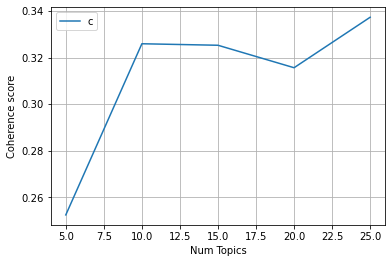

In [195]:
import matplotlib.pyplot as plt
%matplotlib inline

x = range(start, limit, step)

plt.plot(x, coherence_values)

plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')

plt.grid()
plt.show()

        The coherence value seems to be highest (~0.33) for 25 topics

In [199]:
model_lda = model_list[coherence_values.index(max(coherence_values))]  # Model with highest coherence
# model_lda.show_topics(-1)

# Saving model to disk

temp_file = datapath("model_lda")
model_lda.save(temp_file)

# To load from disk: model_lda = LdaModel.load(temp_file)

### Doc2Vec

In [200]:
def doc2vec(data_final):
    '''
    Input: Cleaned and preprocessed data
    Output: doc2vec model trained on given data
    '''
    # tagging documents
    tagged_data = [TaggedDocument(words=words, tags=[str(i)]) for i, words in enumerate(data_final)]  
    
    model = Doc2Vec(tagged_data, window=4, min_count=1, workers=10)
    
    return model

In [202]:
model_doc2vec = doc2vec(data_final)
model_doc2vec

In [201]:
# Saving model to disk
fname = get_tmpfile("model_doc2vec")
model_doc2vec.save(fname)

# To load from disk: model = Doc2Vec.load(fname)